In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

import numpy as np
import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from functionMaths import *

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, protocol = 'tcp', host = '137.129.155.67')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:8787/status,
Dashboard: http://137.129.155.67:8787/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:35677,Workers: 1
Dashboard: http://137.129.155.67:8787/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:34101,Total threads: 4
Dashboard: http://137.129.155.67:43215/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
wave_OLR = 'OLR_Kelvin'
lat_Ref = 0
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'
coeff = 1


In [3]:
ds = xr.open_mfdataset(indir_data + '*.nc', chunks = {'time' : 1000}, parallel = True)
ds_DT = ds.differentiate('time', datetime_unit = "s")

# Sans symetrie

In [4]:
ds_phase = xr.open_mfdataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/PHASE/TEMP/*OLR_Kelvin.nc', 
                             chunks = {'time':1000, 'phase' : 1})
# ds_phase = xr.where(ds_phase['magnitude'] < 1.3, np.nan, ds_phase)
# ds_phase['vect_x'] = np.cos(ds_plot.amplitude) * ds_plot.magnitude
# ds_phase['vect_y'] = np.sin(ds_plot.amplitude) * ds_plot.magnitude
# ds_phase = ds_plot.chunk({'time' : 1, 'lat' : -1})
ds_phase

,Array,Chunk
Bytes,270.84 GiB,8.24 MiB
Shape,"(52592, 60, 360, 32)","(1000, 3, 360, 1)"
Count,67860 Tasks,33920 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,270.84 GiB,8.24 MiB
Shape,"(52592, 60, 360, 32)","(1000, 3, 360, 1)"
Count,67860 Tasks,33920 Chunks
Type,float64,numpy.ndarray


In [5]:
da = ds[wave_OLR] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
_ds_phase = ds_phase.sel(phase = 0, method = 'nearest').persist()
da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_62728/350570123.py", line 4, in <module>
    da_p = da_p.mean(dim = ['time']).load()
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/dataarray.py", line 925, in load
    ds = self._to_temp_dataset().load(**kwargs)
  File "/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/dataset.py", line 862, in load
    evaluated_data = da.compute(*lazy_data.values(), **kwargs)



KeyboardInterrupt



ValueError: DataArray must be 2d

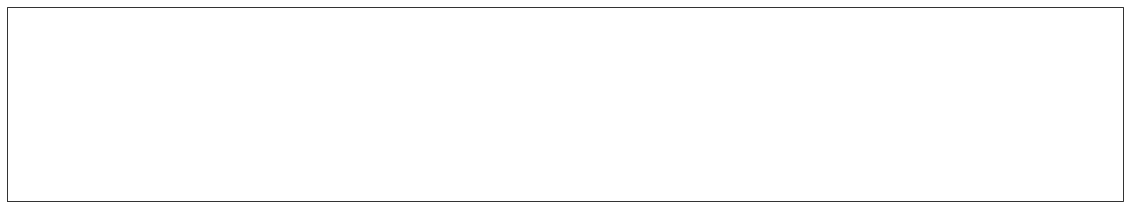

In [6]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -12.0, 0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d'OLR pour Kelvin (phase 0) sans latitude de reference")
plt.savefig(outdir_fig + 'mean_OLR_Kelvin_phase0.png')

In [5]:
da = ds[wave_OLR] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 0, lat= lat_Ref,method = 'nearest')
del _ds_phase['lat']
_ds_phase = _ds_phase.expand_dims(lat = ds['lat'], axis = 1)

da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

<xarray.DataArray 'OLR_Kelvin' (lat: 60, lon: 360)>
array([[-0.45257834, -0.37622072,  0.01150773, ..., -0.4399591 ,
        -0.35279251, -0.48721555],
       [-0.627943  , -0.50287793, -0.16599571, ..., -0.56425903,
        -0.48740475, -0.71477613],
       [-0.78902722, -0.62280793, -0.30910288, ..., -0.69117399,
        -0.62482404, -0.91424221],
       ...,
       [-0.89012342, -0.34776245, -0.23174204, ..., -0.80909599,
        -1.04162234, -0.88553498],
       [-0.65497539, -0.21294029, -0.03228026, ..., -0.59375905,
        -0.76461238, -0.68838628],
       [-0.61854525, -0.2681452 , -0.05895213, ..., -0.50163807,
        -0.67821473, -0.61740314]])
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    phase    int64 0

NameError: name 'outdir_fig' is not defined

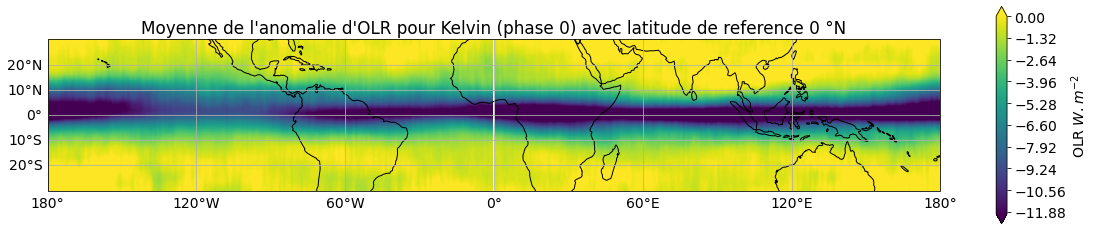

In [6]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -12.0, 0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d'OLR pour Kelvin (phase 0) avec latitude de reference 0 °N")
plt.savefig(outdir_fig + 'mean_OLR_Kelvin_phase0_Ref0.png')

In [ ]:
da = ds_DT[wave_OLR] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
_ds_phase = ds_phase.sel(phase = 0, method = 'nearest')
da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -5.0, 5.0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d/dt(OLR) pour Rossby (phase 8) sans latitude de reference")
plt.savefig(outdir_fig + 'mean_OLR_Kelvin_phase8.png')

In [ ]:
da = ds[wave_OLR] # .sel(time=ds.time.dt.month.isin([4, 5, 6]))
# for j in range(-20,20,2):
_ds_phase = ds_phase.sel(phase = 0, lat= lat_Ref,method = 'nearest')
del _ds_phase['lat']
_ds_phase = _ds_phase.expand_dims(lat = ds['lat'], axis = 1)

da_p = da.where(_ds_phase['amplitude'].isnull() != True)
da_p = da_p.mean(dim = ['time']).load()
da_p

In [ ]:
plt.rc("figure", figsize=(16,4))
# plt.rc("figure", figsize=(20,14))
vmin, vmax = -5.0, 5.0
cmap ='viridis'
    
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'
           }
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)

#####################################################################################
fig, axis = plt.subplots( 1, 1, 
    figsize=(20,4), subplot_kw={'projection': map_proj})

da_p.plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title("Moyenne de l'anomalie d/dt(OLR) pour Rossby (phase 8) avec latitude de reference 10 °N")
plt.savefig(outdir_fig + 'mean_OLR_Kelvin_phase8_ref0.png')